In [1]:
import pandas as pd
import networkx as nx
import math
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

SNA DEL TRAFFICO BENIGNO

In [2]:
# Caricamento file
PATH = "C:/Users/nicde/OneDrive/Desktop/Università/Ancona/DS/Data-Science/datasets/GeneratedLabelledFlows/TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv"

df = pd.read_csv(PATH)

# Pulisce i nomi delle colonne rimuovendo spazi all'inizio e alla fine
df.columns = df.columns.str.strip()
print(df.columns.tolist())

# Conversione timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Ordinamento temporale
df = df.sort_values('Timestamp')

# Definizione finestra (esempio: primi 15 minuti)
start_time = df['Timestamp'].iloc[0]
end_time = start_time + pd.Timedelta(minutes=15)

df_15min = df[
    (df['Timestamp'] >= start_time) &
    (df['Timestamp'] < end_time)
]

#Verifica che sia effettivamente benigno, se presente la colonna Label
if "Label" in df_15min.columns:
    print(df_15min["Label"].value_counts(dropna=False).head(10))

['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH 

In [3]:
# Estrazione archi diretti (flow direction: Src IP -> Dst IP)
edges = df_15min[["Source IP", "Destination IP"]].dropna()

# Aggregazione: conteggio flussi per coppia (Src IP, Dst IP)
edges_w = (
    edges.groupby(["Source IP", "Destination IP"])
         .size()
         .reset_index(name="weight")
)

# Lista IP unici (sorgenti e destinazioni)
ips = pd.unique(edges_w[["Source IP", "Destination IP"]].values.ravel())

# Mappa IP -> ID intero
ip_to_id = {ip: i for i, ip in enumerate(ips)}

# Applica mappatura
edges_w["src_id"] = edges_w["Source IP"].map(ip_to_id)
edges_w["dst_id"] = edges_w["Destination IP"].map(ip_to_id)

mapping_df = pd.DataFrame({"ip": list(ip_to_id.keys()), "id": list(ip_to_id.values())})
mapping_df.to_csv("ip_id_mapping_benign_15m.csv", index=False)

In [4]:
# Salvataggio file di archi pesati
EDGE_TXT = "cic_benign_15m_edges_weighted.txt"

edges_w[["src_id", "dst_id", "weight"]].to_csv(
    EDGE_TXT,
    sep=" ",
    index=False,
    header=False
)

In [5]:
#Creazione del grafo con NetworkX
data = pd.read_csv(EDGE_TXT, sep=" ", header=None, names=["src", "target", "weight"])

G = nx.DiGraph()
for _, r in data.iterrows():
    G.add_edge(int(r["src"]), int(r["target"]), weight=int(r["weight"]))

In [6]:
# Analisi del grafo
def analizza_grafo_diretto_pesato(G: nx.DiGraph, weight_attr: str = "weight"):
    """
    Analisi base per grafo DIRETTO e PESATO.
    Per distanze (raggio/diametro) si usa un costo inverso: cost = 1/weight.
    """
    if not isinstance(G, (nx.DiGraph, nx.MultiDiGraph)):
        raise TypeError("Questa funzione è pensata per grafi diretti (DiGraph/MultiDiGraph).")

    # Nodi e archi
    n_nodi = G.number_of_nodes()
    n_archi = G.number_of_edges()

    # Densità (per grafi diretti NetworkX gestisce la formula corretta)
    densita = nx.density(G)

    # Connettività (diretto): debole vs forte
    weakly = nx.is_weakly_connected(G) if n_nodi > 0 else False
    strongly = nx.is_strongly_connected(G) if n_nodi > 0 else False

    # Clustering: su diretti spesso si riporta sul grafo "semplificato" non diretto
    # (approccio standard quando si confronta con esempi di Graph non orientati)
    G_u = G.to_undirected()
    clustering_medio = nx.average_clustering(G_u)

    # Raggio/diametro/periferia: calcolabili solo su un grafo connesso (qui: componente connessa massima)
    # e con una metrica di distanza coerente con i pesi:
    # weight = numero di flussi (forza) -> cost = 1/weight (più flussi => distanza minore)
    raggio = diametro = periferia = None

    if n_nodi > 0 and G_u.number_of_edges() > 0:
        # Componente connessa più grande (su grafo non diretto)
        largest_cc_nodes = max(nx.connected_components(G_u), key=len)
        H = G_u.subgraph(largest_cc_nodes).copy()

        # Costruzione attributo 'cost' = 1/weight (gestione robusta)
        for u, v, data in H.edges(data=True):
            w = data.get(weight_attr, 1)
            try:
                w = float(w)
            except Exception:
                w = 1.0
            data["cost"] = (1.0 / w) if w > 0 else math.inf

        # Se la componente ha almeno 2 nodi si possono calcolare eccentricità/raggio/diametro
        if H.number_of_nodes() >= 2:
            # eccentricity usa 'distance' come nome parametro
            ecc = nx.eccentricity(H, weight="cost")
            raggio = min(ecc.values())
            diametro = max(ecc.values())
            periferia = [n for n, e in ecc.items() if e == diametro]

    # Stampa risultati
    print(f"Numero di nodi: {n_nodi}")
    print(f"Numero di archi: {n_archi}")
    print(f"Densità (diretto): {densita:.6f}")
    print(f"Connesso (debole / weakly): {weakly}")
    print(f"Connesso (forte / strongly): {strongly}")
    print(f"Average clustering coefficient (su versione non diretta): {clustering_medio:.6f}")

    if raggio is not None:
        print("Raggio/Diametro/Periferia calcolati sulla componente connessa più grande (versione non diretta),")
        print("usando cost=1/weight (più flussi => distanza minore).")
        print(f"Raggio: {raggio}")
        print(f"Diametro: {diametro}")
        print(f"Periferia: {periferia}")
    else:
        print("Raggio, diametro e periferia non calcolati (grafo vuoto/non connesso o componente troppo piccola).")


In [7]:
analizza_grafo_diretto_pesato(G, weight_attr="weight")

Numero di nodi: 736
Numero di archi: 1528
Densità (diretto): 0.002825
Connesso (debole / weakly): False
Connesso (forte / strongly): False
Average clustering coefficient (su versione non diretta): 0.011437
Raggio/Diametro/Periferia calcolati sulla componente connessa più grande (versione non diretta),
usando cost=1/weight (più flussi => distanza minore).
Raggio: 1.2
Diametro: 2.3428571428571425
Periferia: [59, 107, 261, 262, 694, 698, 699, 700, 702, 705, 711]


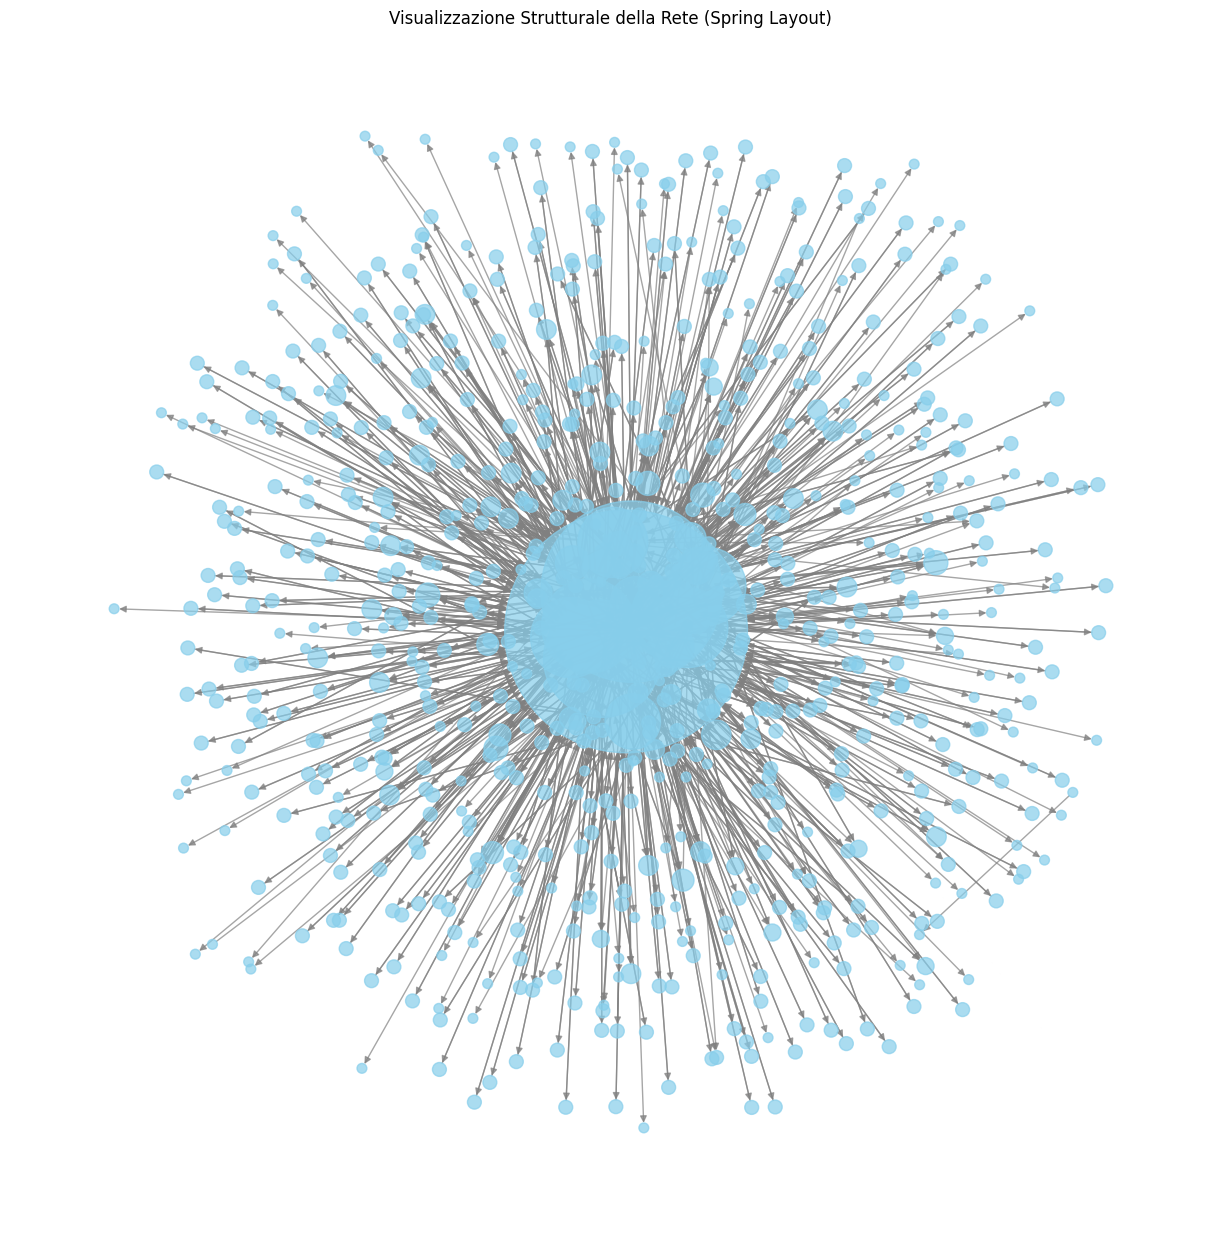

In [8]:
# Imposta la dimensione dei nodi in base al grado (più flussi = nodo più grande)
d = dict(G.degree)
node_sizes = [v * 50 for v in d.values()]

# Calcola la posizione con lo spring layout
pos = nx.spring_layout(G, k=0.15, iterations=20) 

plt.figure(figsize=(12, 12))
nx.draw(G, pos, 
        node_size=node_sizes, 
        node_color='skyblue', 
        with_labels=False,
        edge_color='gray',
        alpha=0.7)

plt.title("Visualizzazione Strutturale della Rete (Spring Layout)")
plt.show()

In [9]:
# Componente debolmente connessa più grande (su grafo diretto)
largest_wcc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_wcc).copy()

print("Nodi H:", H.number_of_nodes(), "Archi H:", H.number_of_edges())

Nodi H: 734 Archi H: 1527


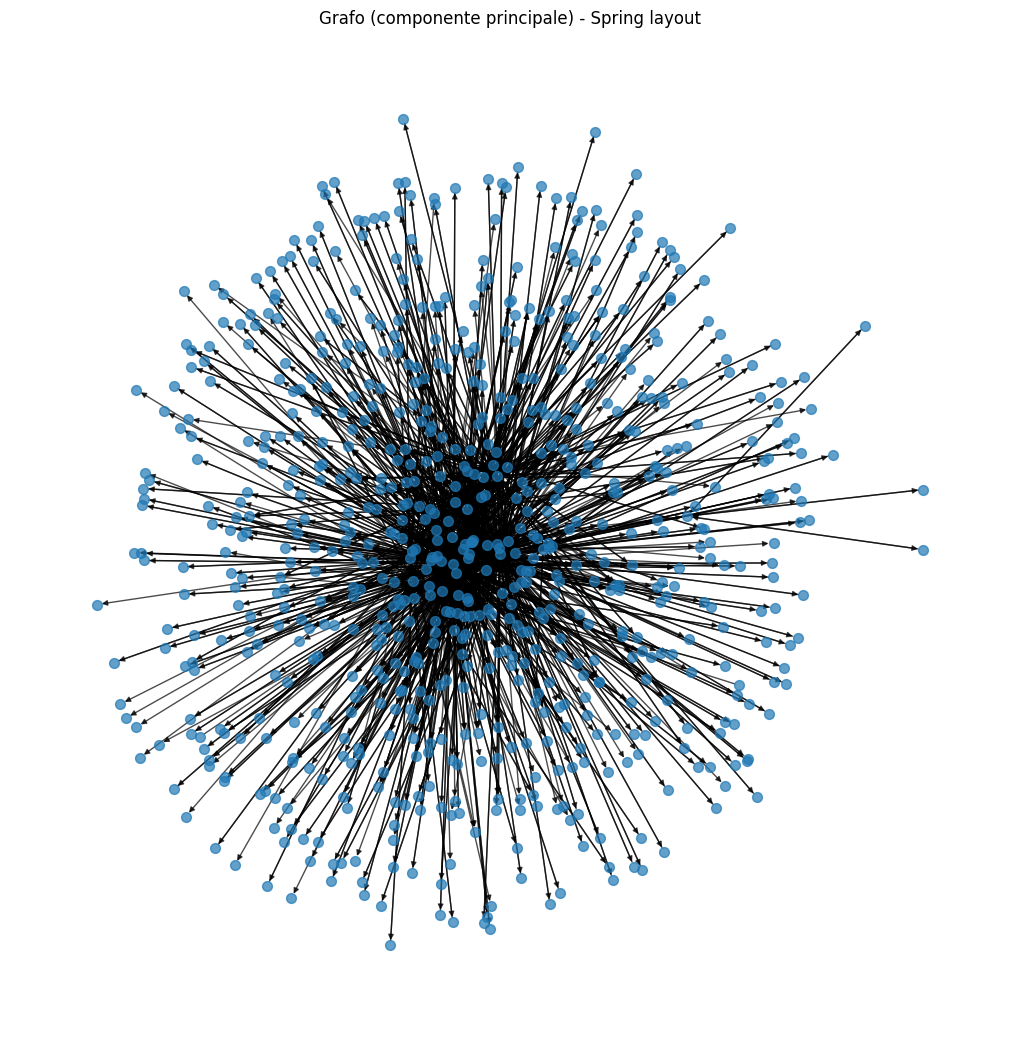

In [10]:
largest_wcc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_wcc).copy()

pos = nx.spring_layout(H.to_undirected(), seed=42)

plt.figure(figsize=(10, 10))
nx.draw(H, pos, with_labels=False, node_size=50, arrows=True, arrowsize=8, alpha=0.7)
plt.title("Grafo (componente principale) - Spring layout")
plt.axis("off")
plt.show()

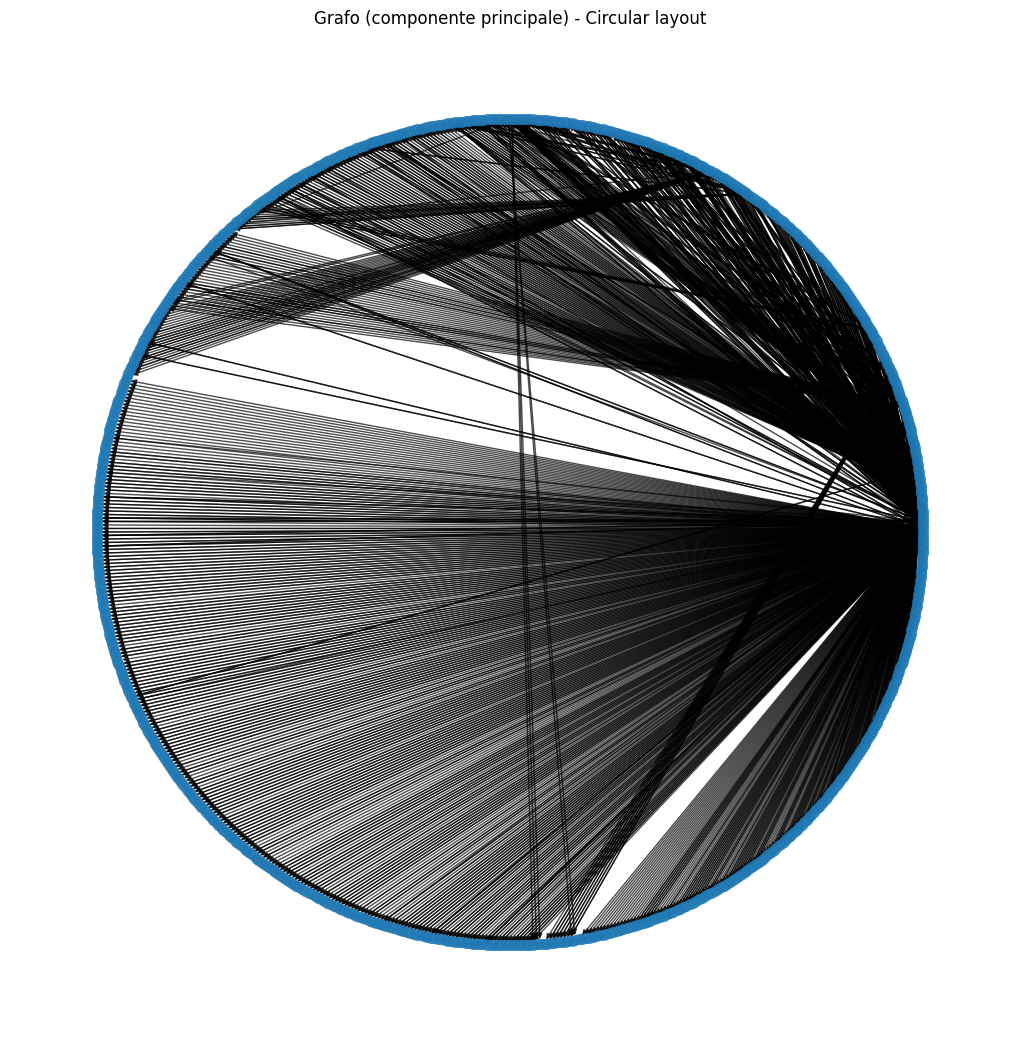

In [ ]:
# Visualizzazione circular 
largest_wcc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_wcc).copy()

pos = nx.circular_layout(H.to_undirected())

plt.figure(figsize=(10, 10))
nx.draw(H, pos, with_labels=False, node_size=50, arrows=True, arrowsize=8, alpha=0.7)
plt.title("Grafo (componente principale) - Circular layout")
plt.axis("off")
plt.show()

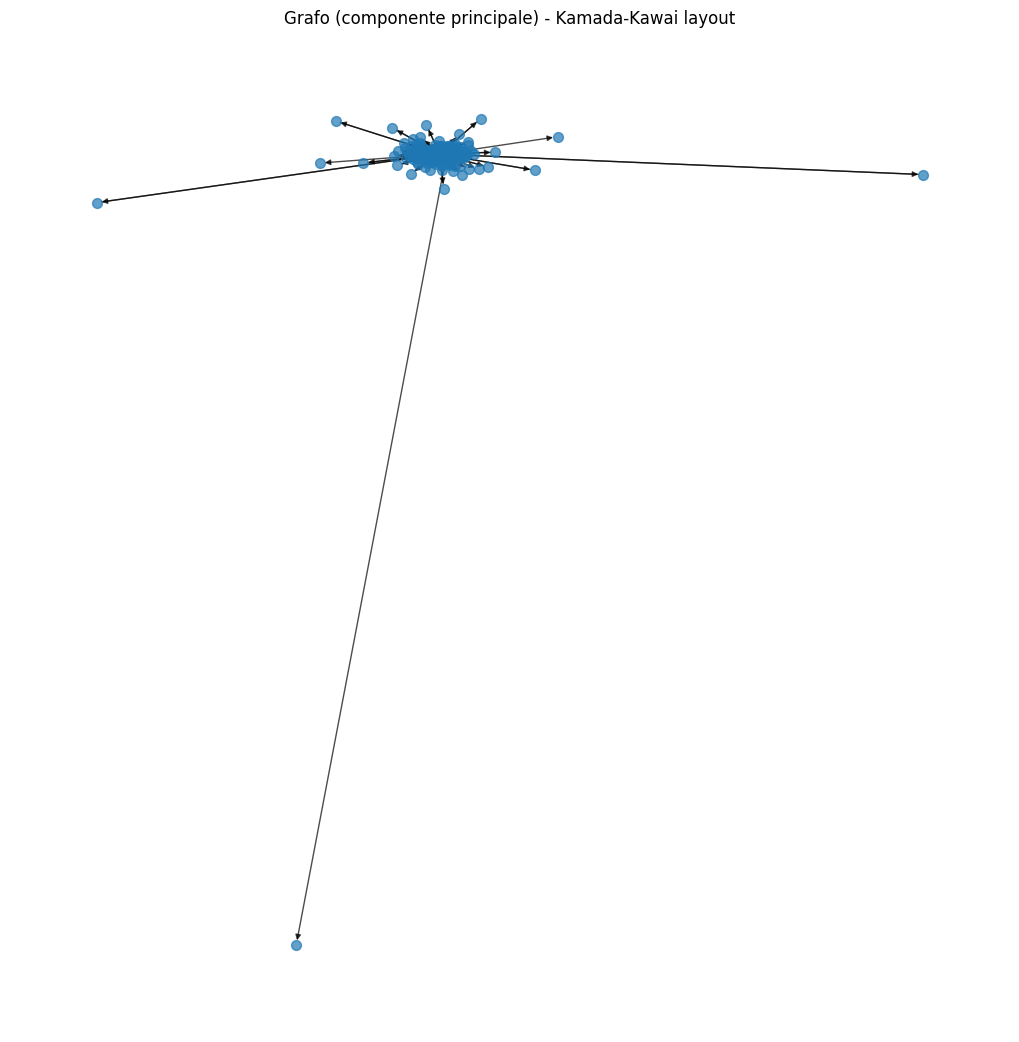

In [ ]:
# Visualizzazione kamada-kawai
largest_wcc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_wcc).copy()

pos = nx.kamada_kawai_layout(H.to_undirected())

plt.figure(figsize=(10, 10))
nx.draw(H, pos, with_labels=False, node_size=50, arrows=True, arrowsize=8, alpha=0.7)
plt.title("Grafo (componente principale) - Kamada-Kawai layout")
plt.axis("off")
plt.show()

In [ ]:
# 1) Costruisci un grafo non diretto per closeness/betweenness/eigenvector "stabili"

# 2) Crea 'cost' = 1/weight (weight = numero flussi => più flussi = più vicinanza)
for u, v, data in U.edges(data=True):
    w = data.get("weight", 1)
    try:
        w = float(w)
    except Exception:
        w = 1.0
    data["cost"] = (1.0 / w) if w > 0 else math.inf

# 3) Centralità
# Degree: su grafo diretto ha più senso separare in/out (in più ti calcolo anche degree_centrality "classica" su U)
in_deg_cent = {n: d/(H.number_of_nodes()-1) for n, d in H.in_degree()}
out_deg_cent = {n: d/(H.number_of_nodes()-1) for n, d in H.out_degree()}
degree_centrality = nx.degree_centrality(U)

# Closeness e betweenness: usa cost come distanza (NOTA: per la tua versione NX closeness usa 'distance', betweenness usa 'weight')
# Se la tua version di closeness non accetta 'distance', usa la riga alternativa commentata sotto.
try:
    closeness_centrality = nx.closeness_centrality(U, distance="cost")
except TypeError:
    # fallback per versioni vecchie: calcolo non pesato (topologia) se 'distance' non è supportato
    closeness_centrality = nx.closeness_centrality(U)

betweenness_centrality = nx.betweenness_centrality(U, weight="cost")

# Eigenvector: su grafo non diretto è più robusta; i pesi qui puoi usarli come intensità (weight="weight")
# Se non converge, aumenta max_iter o usa eigenvector_centrality_numpy.
try:
    eigenvector_centrality = nx.eigenvector_centrality(U, weight="weight", max_iter=2000)
except nx.PowerIterationFailedConvergence:
    eigenvector_centrality = nx.eigenvector_centrality_numpy(U, weight="weight")

# 4) DataFrame (come nel tuo esempio, con l'aggiunta di In/Out-degree)
centrality_df = pd.DataFrame({
    "Node": list(U.nodes),
    "In-Degree Centrality": [in_deg_cent[n] for n in U.nodes],
    "Out-Degree Centrality": [out_deg_cent[n] for n in U.nodes],
    "Degree Centrality": [degree_centrality[n] for n in U.nodes],
    "Closeness Centrality": [closeness_centrality[n] for n in U.nodes],
    "Betweenness Centrality": [betweenness_centrality[n] for n in U.nodes],
    "Eigenvector Centrality": [eigenvector_centrality[n] for n in U.nodes]
})

centrality_sorted_df = centrality_df.copy()
centrality_sorted_df["Node"] = centrality_sorted_df["Node"].astype(str)

# 5) Ordinamenti (come nel tuo esempio)
degree_sorted = centrality_sorted_df.sort_values("Degree Centrality", ascending=False)
print("degree_sorted done")

closeness_sorted = centrality_sorted_df.sort_values("Closeness Centrality", ascending=False)
print("closeness_sorted done")

betweenness_sorted = centrality_sorted_df.sort_values("Betweenness Centrality", ascending=False)
print("betweenness_sorted done")

eigenvector_sorted = centrality_sorted_df.sort_values("Eigenvector Centrality", ascending=False)
print("eigenvector_sorted done")

# (Opzionale) anche per in/out-degree
in_degree_sorted = centrality_sorted_df.sort_values("In-Degree Centrality", ascending=False)
print("in_degree_sorted done")

out_degree_sorted = centrality_sorted_df.sort_values("Out-Degree Centrality", ascending=False)
print("out_degree_sorted done")

# 6) Stampa top/bottom 5 come nel tuo esempio
print("Top 5 Degree Centrality:\n", degree_sorted.head(), "\n")
print("Bottom 5 Degree Centrality:\n", degree_sorted.tail(), "\n")

print("Top 5 Closeness Centrality:\n", closeness_sorted.head(), "\n")
print("Bottom 5 Closeness Centrality:\n", closeness_sorted.tail(), "\n")

print("Top 5 Betweenness Centrality:\n", betweenness_sorted.head(), "\n")
print("Bottom 5 Betweenness Centrality:\n", betweenness_sorted.tail(), "\n")

print("Top 5 Eigenvector Centrality:\n", eigenvector_sorted.head(), "\n")
print("Bottom 5 Eigenvector Centrality:\n", eigenvector_sorted.tail(), "\n")

# (Opzionale) top/bottom in/out-degree
print("Top 5 In-Degree Centrality:\n", in_degree_sorted.head(), "\n")
print("Top 5 Out-Degree Centrality:\n", out_degree_sorted.head(), "\n")

degree_sorted done
closeness_sorted done
betweenness_sorted done
eigenvector_sorted done
in_degree_sorted done
out_degree_sorted done
Top 5 Degree Centrality:
    Node  In-Degree Centrality  Out-Degree Centrality  Degree Centrality  \
1     1              0.369714               0.463847           0.465211   
3     3              0.189632               0.275580           0.275580   
12   12              0.085948               0.109141           0.109141   
7     7              0.058663               0.066849           0.066849   
36   36              0.031378               0.058663           0.065484   

    Closeness Centrality  Betweenness Centrality  Eigenvector Centrality  
1               1.753396                0.718102                0.311913  
3               1.585398                0.384940                0.001116  
12              1.749338                0.454694                0.151229  
7               1.734547                0.089571                0.081678  
36            

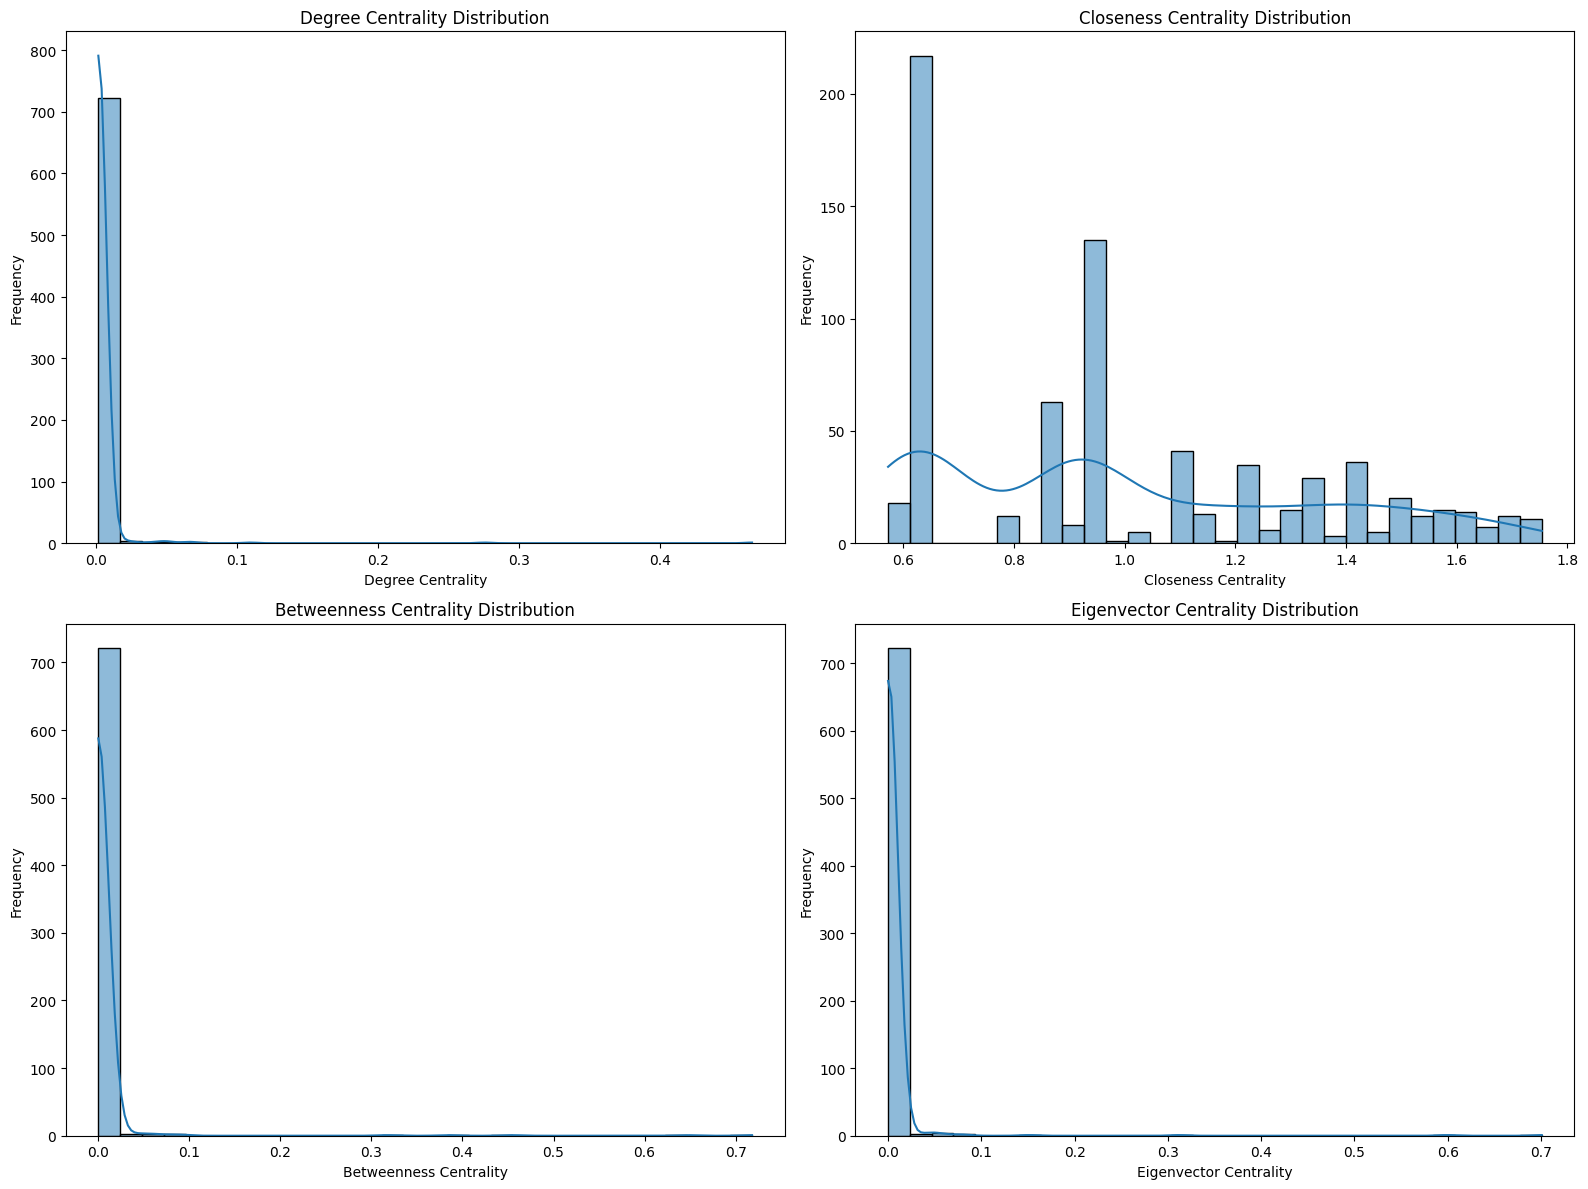

In [15]:
plt.figure(figsize=(16, 12))

# Degree Centrality
plt.subplot(2, 2, 1)
sns.histplot(
    degree_sorted["Degree Centrality"],
    kde=True,
    bins=30
)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")

# Closeness Centrality
plt.subplot(2, 2, 2)
sns.histplot(
    closeness_sorted["Closeness Centrality"],
    kde=True,
    bins=30
)
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")

# Betweenness Centrality
plt.subplot(2, 2, 3)
sns.histplot(
    betweenness_sorted["Betweenness Centrality"],
    kde=True,
    bins=30
)
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")

# Eigenvector Centrality
plt.subplot(2, 2, 4)
sns.histplot(
    eigenvector_sorted["Eigenvector Centrality"],
    kde=True,
    bins=30
)
plt.title("Eigenvector Centrality Distribution")
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

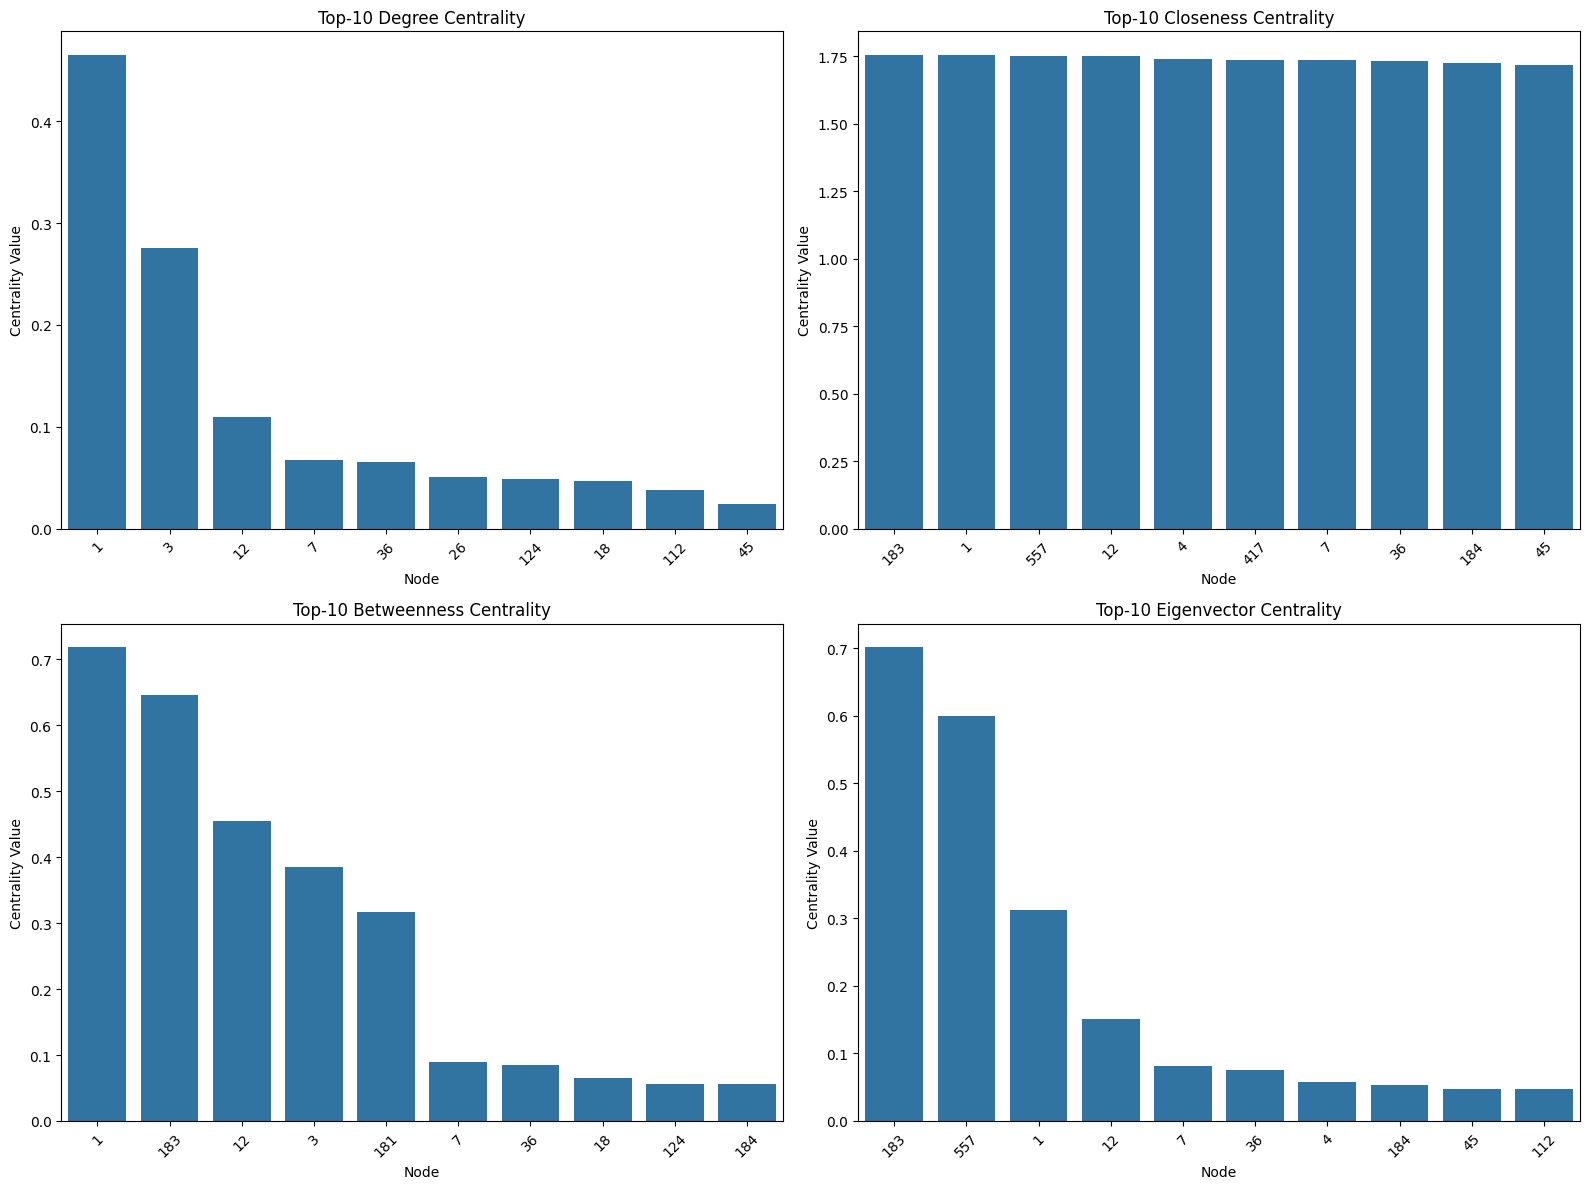

In [16]:
TOP_K = 10

plt.figure(figsize=(16, 12))

# Degree Centrality (top-k)
plt.subplot(2, 2, 1)
sns.barplot(
    x="Node",
    y="Degree Centrality",
    data=degree_sorted.head(TOP_K)
)
plt.title("Top-10 Degree Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Closeness Centrality (top-k)
plt.subplot(2, 2, 2)
sns.barplot(
    x="Node",
    y="Closeness Centrality",
    data=closeness_sorted.head(TOP_K)
)
plt.title("Top-10 Closeness Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Betweenness Centrality (top-k)
plt.subplot(2, 2, 3)
sns.barplot(
    x="Node",
    y="Betweenness Centrality",
    data=betweenness_sorted.head(TOP_K)
)
plt.title("Top-10 Betweenness Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Eigenvector Centrality (top-k)
plt.subplot(2, 2, 4)
sns.barplot(
    x="Node",
    y="Eigenvector Centrality",
    data=eigenvector_sorted.head(TOP_K)
)
plt.title("Top-10 Eigenvector Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

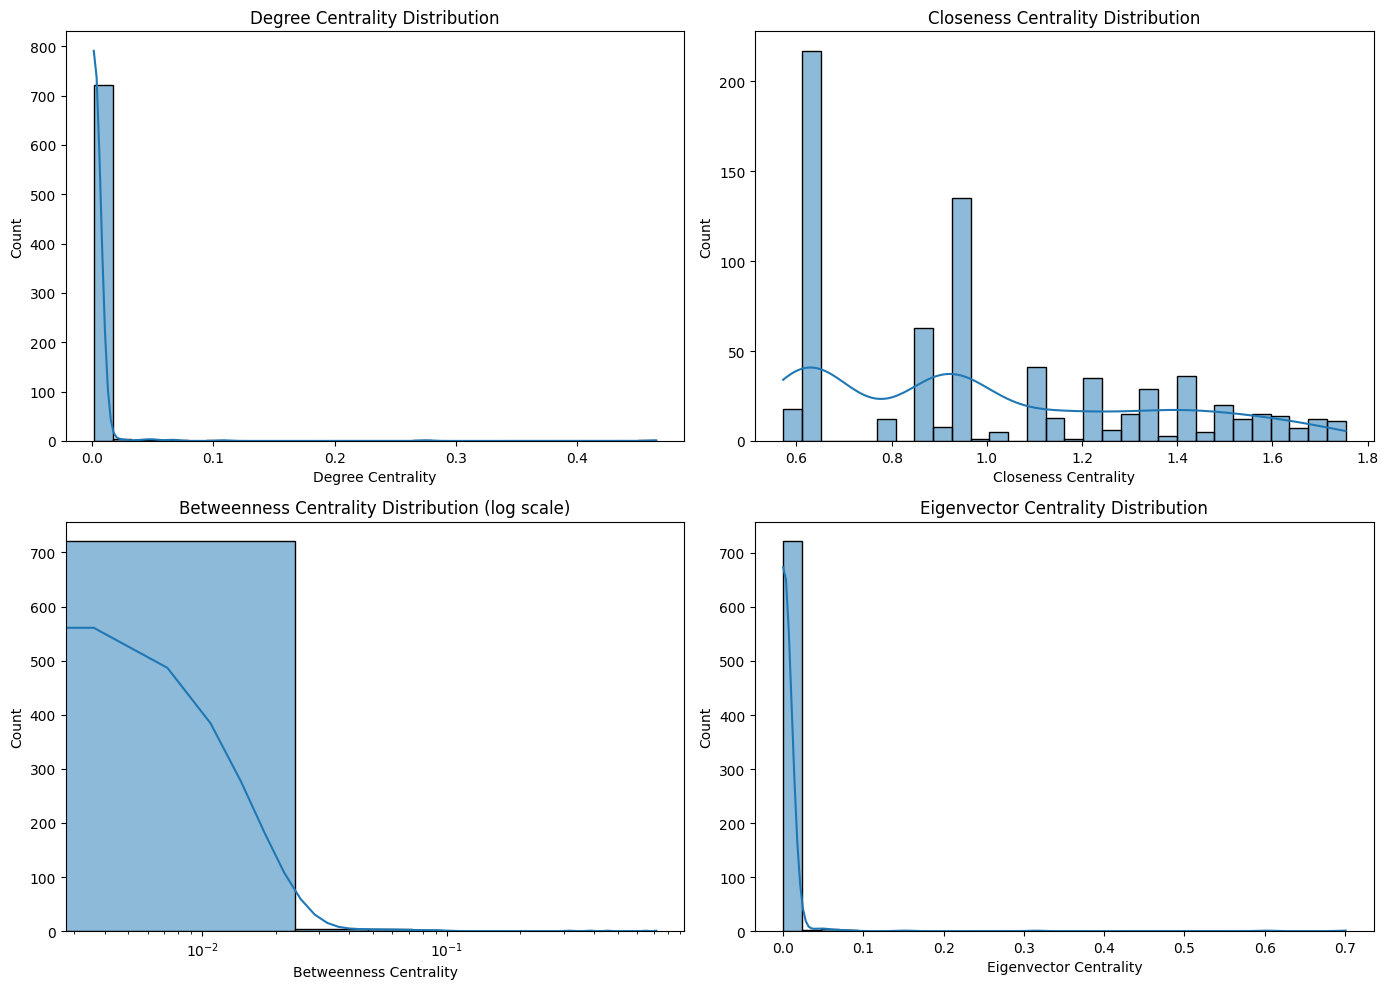

In [17]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(centrality_df["Degree Centrality"], kde=True, bins=30)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 2)
sns.histplot(centrality_df["Closeness Centrality"], kde=True, bins=30)
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 3)
sns.histplot(centrality_df["Betweenness Centrality"], kde=True, bins=30)
plt.xscale("log")
plt.title("Betweenness Centrality Distribution (log scale)")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 4)
sns.histplot(centrality_df["Eigenvector Centrality"], kde=True, bins=30)
plt.title("Eigenvector Centrality Distribution")
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


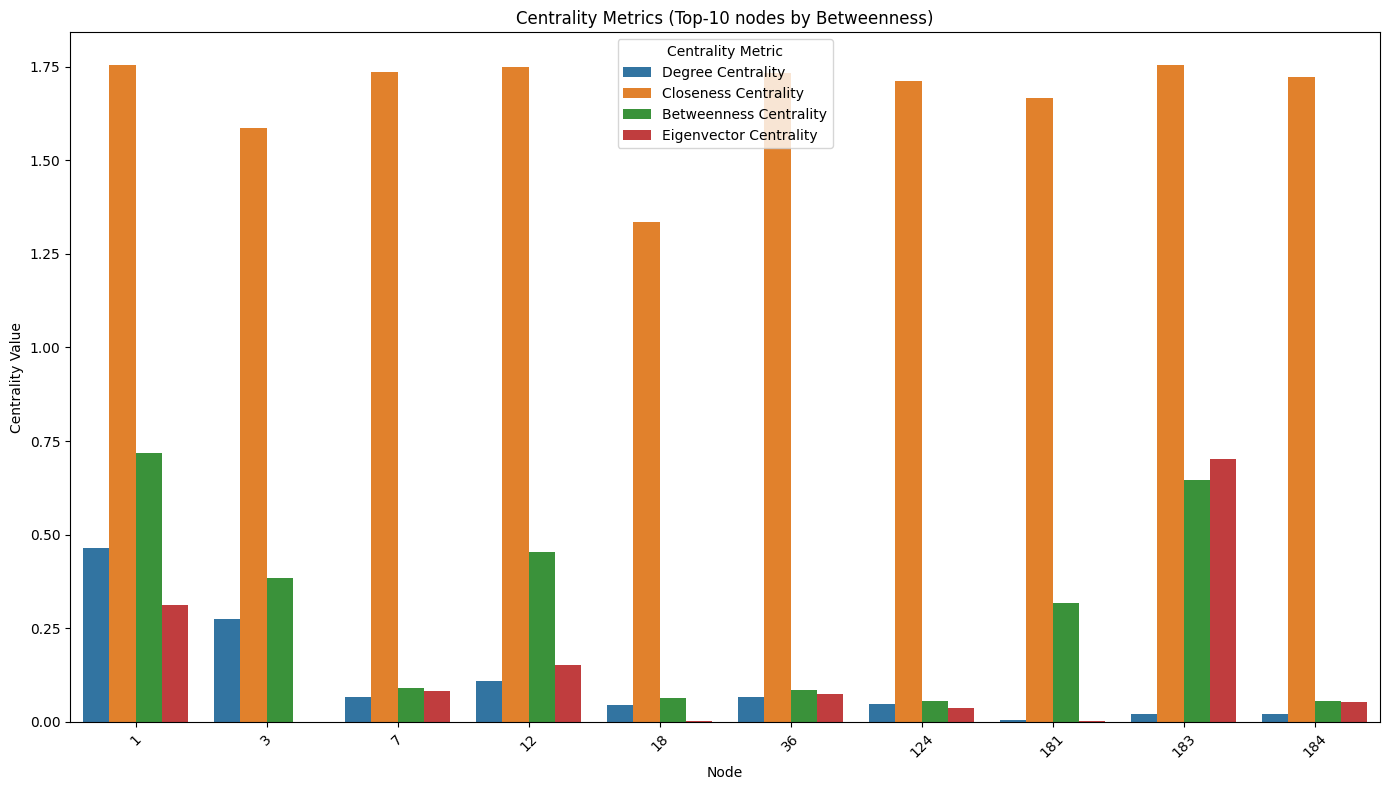

In [ ]:
TOP_K = 10

# Assicura coerenza dei tipi
centrality_df_plot = centrality_df.copy()
centrality_df_plot["Node"] = centrality_df_plot["Node"].astype(str)

top_nodes = betweenness_sorted.head(TOP_K)["Node"].astype(str)

centrality_topk = centrality_df_plot[centrality_df_plot["Node"].isin(top_nodes)]

centrality_melted = pd.melt(
    centrality_topk,
    id_vars="Node",
    value_vars=[
        "Degree Centrality",
        "Closeness Centrality",
        "Betweenness Centrality",
        "Eigenvector Centrality"
    ],
    var_name="Centrality Metric",
    value_name="Value"
)


plt.figure(figsize=(14, 8))
sns.barplot(
    data=centrality_melted,
    x="Node",
    y="Value",
    hue="Centrality Metric"
)
plt.title("Centrality Metrics (Top-10 nodes by Betweenness)")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



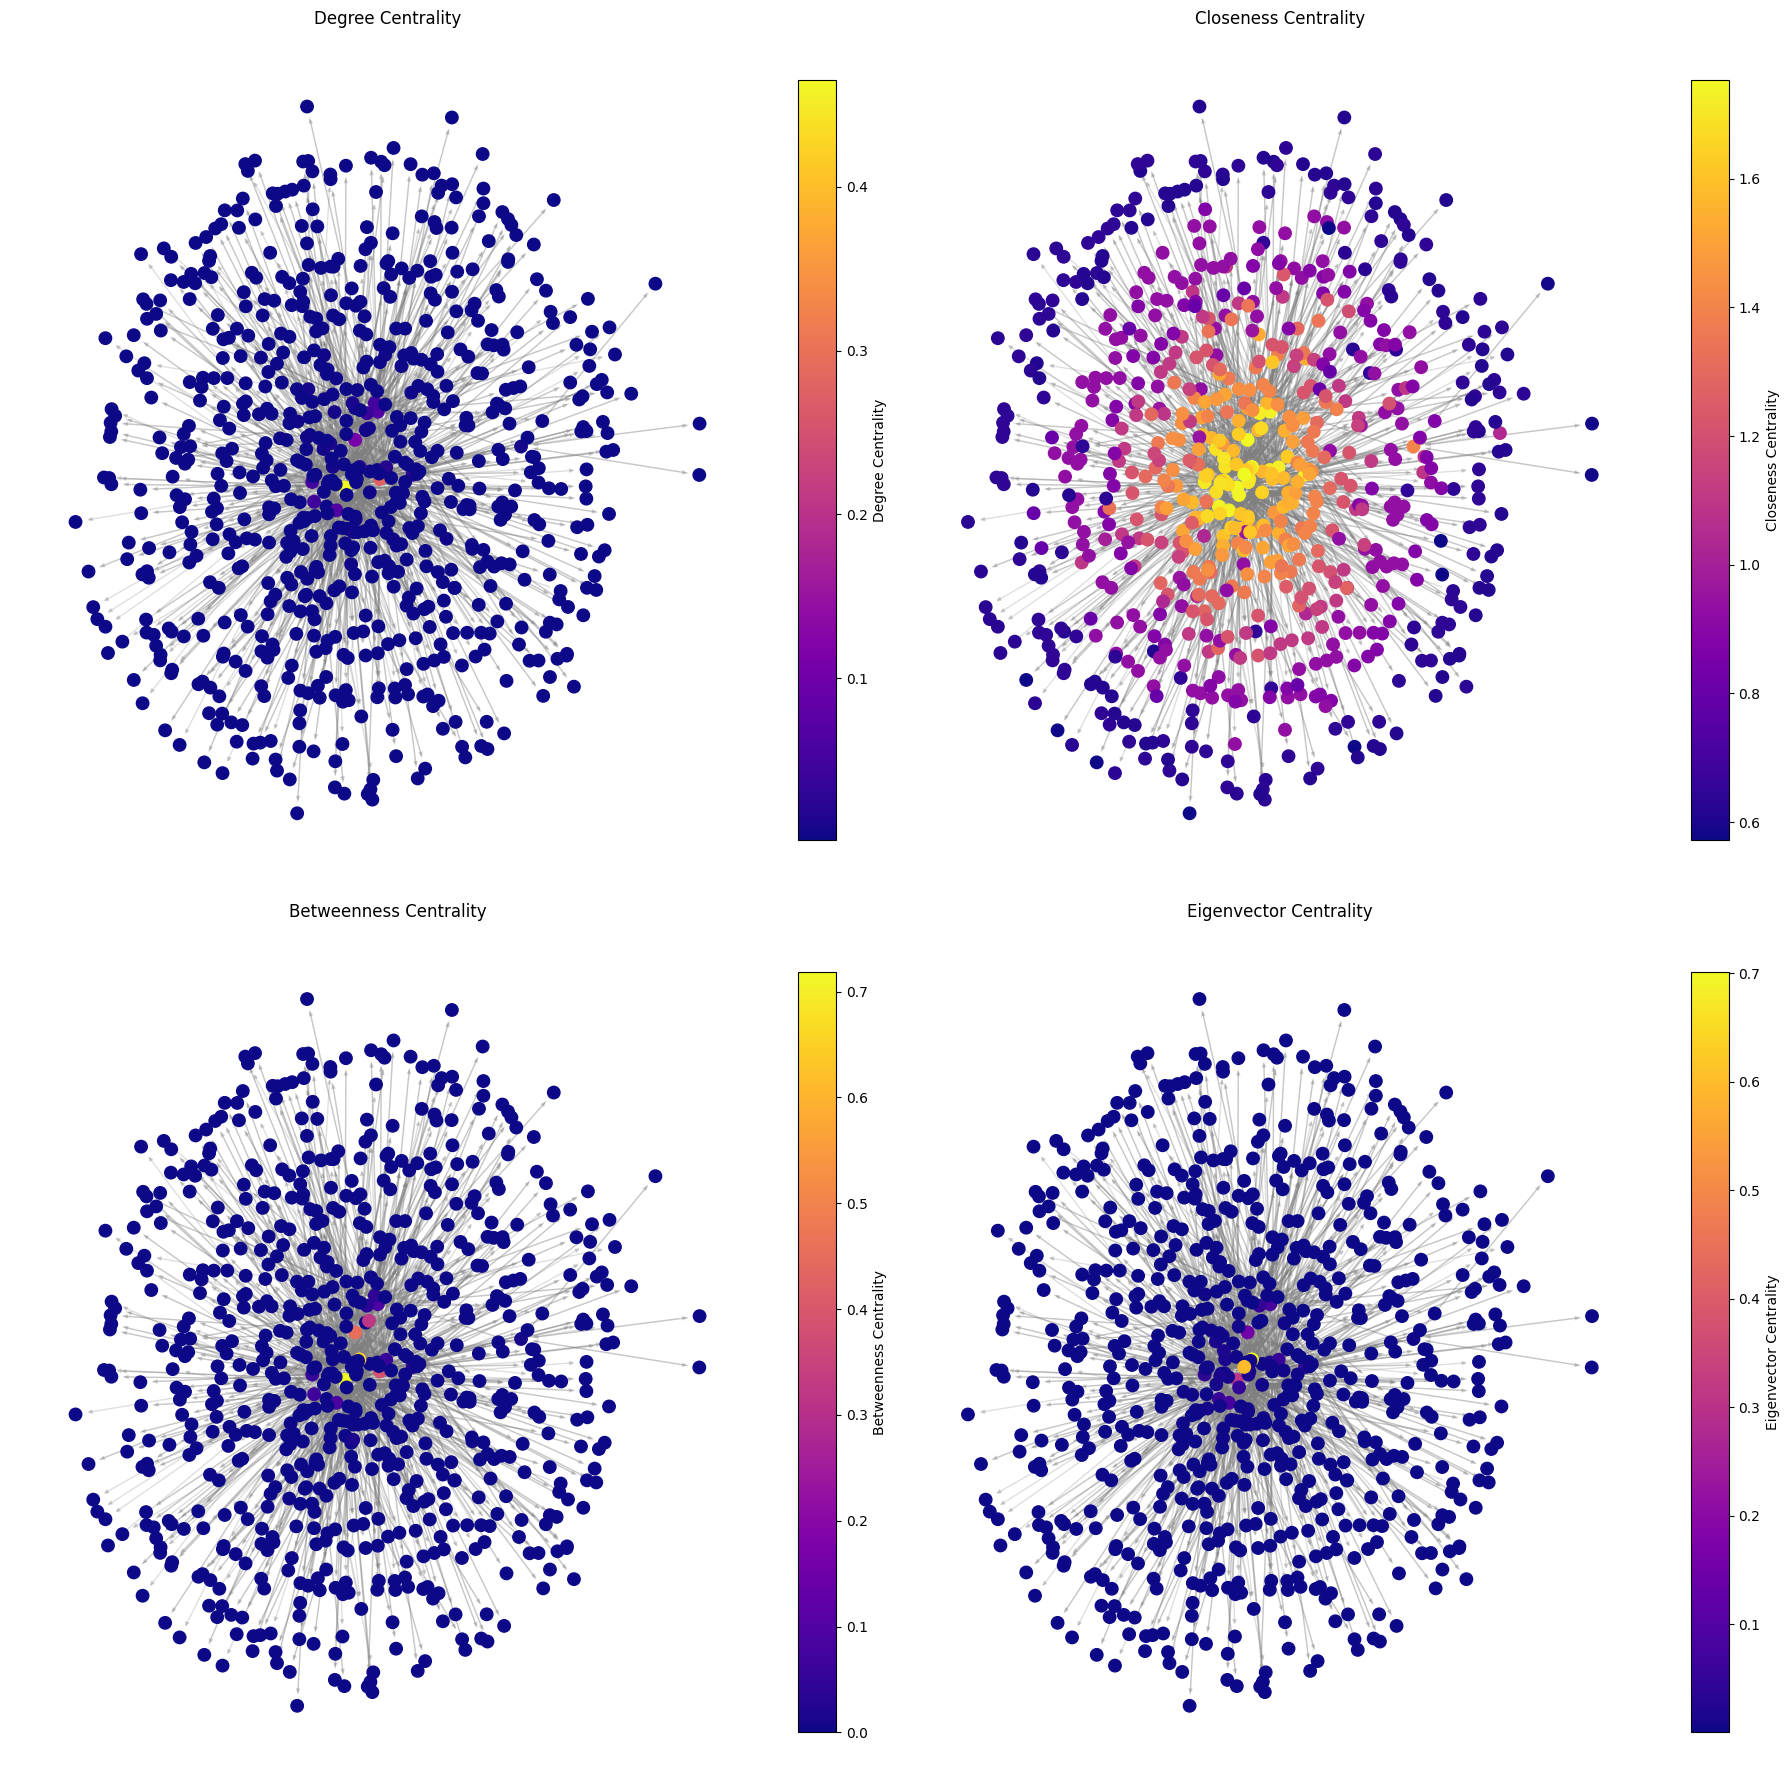

In [ ]:
# Viene effetuato il calcolo su H ovvero la componente debolmente connessa più grande definita prima
U = H.to_undirected()

# Posizione unica (calcolata una sola volta)
pos = nx.spring_layout(U, seed=42)

plt.figure(figsize=(18, 18))

node_size = 80          # per 700+ nodi deve essere piccolo
with_labels = False     # etichette OFF su grafi grandi (se vuoi, le metti solo su top-k)
edge_color = "gray"
edge_alpha = 0.25

# Funzione helper per un pannello
def draw_centrality_subplot(ax, graph, pos, cent_dict, title):
    values = [cent_dict.get(node, 0.0) for node in graph.nodes()]

    nx.draw_networkx_nodes(
        graph, pos,
        node_color=values,
        node_size=node_size,
        cmap="plasma",
        ax=ax
    )
    nx.draw_networkx_edges(
        graph, pos,
        edge_color=edge_color,
        alpha=edge_alpha,
        arrows=True,
        arrowsize=6,
        ax=ax
    )

    if with_labels:
        nx.draw_networkx_labels(graph, pos, font_size=6, ax=ax)

    sm = plt.cm.ScalarMappable(
        cmap="plasma",
        norm=plt.Normalize(vmin=min(values), vmax=max(values))
    )
    sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label=title)

    ax.set_title(title)
    ax.axis("off")

# 1) Degree
ax = plt.subplot(2, 2, 1)
draw_centrality_subplot(ax, H, pos, degree_centrality, "Degree Centrality")

# 2) Closeness
ax = plt.subplot(2, 2, 2)
draw_centrality_subplot(ax, H, pos, closeness_centrality, "Closeness Centrality")

# 3) Betweenness
ax = plt.subplot(2, 2, 3)
draw_centrality_subplot(ax, H, pos, betweenness_centrality, "Betweenness Centrality")

# 4) Eigenvector
ax = plt.subplot(2, 2, 4)
draw_centrality_subplot(ax, H, pos, eigenvector_centrality, "Eigenvector Centrality")

plt.tight_layout()
plt.show()


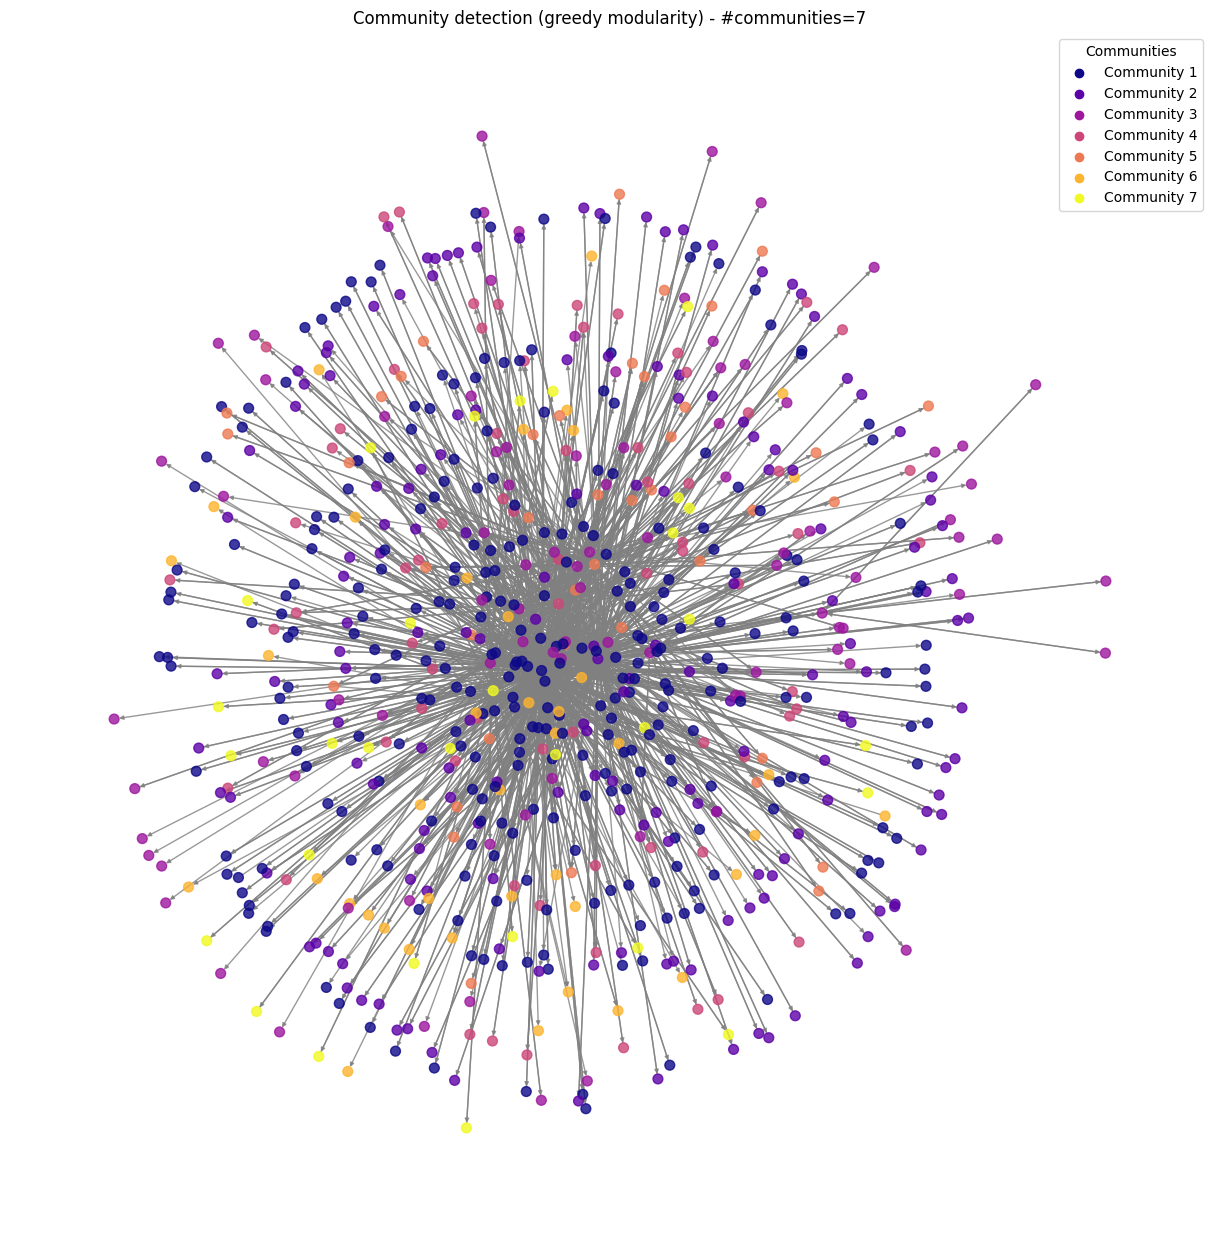

In [20]:
pos = nx.spring_layout(U, seed=42)

#Community detection
communities = list(greedy_modularity_communities(U))

community_colors = plt.cm.plasma(np.linspace(0, 1, len(communities)))
node_color = {}

for i, community in enumerate(communities):
    for node in community:
        node_color[node] = community_colors[i]

colors = [node_color.get(node, (0.7, 0.7, 0.7, 1.0)) for node in U.nodes]

# Plot
plt.figure(figsize=(12, 12))
nx.draw(
    H, pos,
    node_color=colors,
    with_labels=False,      
    node_size=50,
    edge_color="gray",
    alpha=0.8,
    arrows=True,
    arrowsize=6
)

# Legenda: solo se comunità poche (altrimenti è inutilizzabile)
MAX_LEGEND = 12
if len(communities) <= MAX_LEGEND:
    for i in range(len(communities)):
        plt.scatter([], [], color=community_colors[i], label=f'Community {i+1}')
    plt.legend(title="Communities", loc="best")

plt.title(f"Community detection (greedy modularity) - #communities={len(communities)}")
plt.axis("off")
plt.show()

ANALISI DELLE STRUTTURE DEL TRAFFICO BENIGNO

In [21]:
# Versione NON diretta per analisi strutturale
U = H.to_undirected()
cliques = list(nx.find_cliques(U))

clique_count = len(cliques)
max_clique_size = max(len(c) for c in cliques)
largest_cliques = [c for c in cliques if len(c) == max_clique_size]
print("Numero di clique:", clique_count)
print("Dimensione massima clique:", max_clique_size)
print("Largest cliques:", largest_cliques)

Numero di clique: 843
Dimensione massima clique: 5
Largest cliques: [[1, 26, 184, 182, 183], [112, 26, 182, 184, 183], [124, 26, 182, 184, 183]]


In [22]:
triangles = nx.triangles(U)
triadic_closures_count = sum(triangles.values()) // 3
print("Numero di triadi chiuse (triangoli):", triadic_closures_count)

Numero di triadi chiuse (triangoli): 59


In [23]:
k_core_dict = {}

max_degree = max(dict(U.degree()).values())

for k in range(1, max_degree + 1):
    k_core = nx.k_core(U, k=k)
    if k_core.number_of_nodes() > 0:
        k_core_dict[k] = k_core

k_core_summary = {k: core.number_of_nodes() for k, core in k_core_dict.items()}
print("k-core summary (k : numero nodi):", k_core_summary)

max_k = max(k_core_dict.keys())
largest_k_core = k_core_dict[max_k]

print("Max k:", max_k)
print("Nodi nel largest k-core:", list(largest_k_core.nodes))

k-core summary (k : numero nodi): {1: 734, 2: 96, 3: 41, 4: 23, 5: 18}
Max k: 5
Nodi nel largest k-core: [1, 3, 36, 133, 7, 200, 139, 12, 45, 112, 147, 182, 151, 184, 183, 26, 124, 158]


In [24]:
ego_node = 1  #si sceglie un nodo rilevante (es. top-betweenness)
ego_network = nx.ego_graph(U, ego_node)
print(
    f"Ego-network del nodo {ego_node}: "
    f"{ego_network.number_of_nodes()} nodi, "
    f"{ego_network.number_of_edges()} archi"
)

Ego-network del nodo 1: 342 nodi, 354 archi


Closed triads (triangles): 59
Connected triples: 86607
Open triads: 86548

Triadi chiuse che contengono 1 e 183:
  [1, 183, 26]
  [1, 183, 182]
  [1, 183, 184]

Triadi aperte che contengono 1 e 183:
  [1, 183, 0]
  [1, 183, 3]
  [1, 183, 4]
  [1, 183, 7]
  [1, 183, 8]
  [1, 183, 9]
  [1, 183, 10]
  [1, 183, 12]
  [1, 183, 13]
  [1, 183, 14]
  [1, 183, 16]
  [1, 183, 18]
  [1, 183, 20]
  [1, 183, 21]
  [1, 183, 22]
  [1, 183, 29]
  [1, 183, 31]
  [1, 183, 32]
  [1, 183, 34]
  [1, 183, 35]
  [1, 183, 36]
  [1, 183, 38]
  [1, 183, 39]
  [1, 183, 40]
  [1, 183, 41]
  [1, 183, 43]
  [1, 183, 45]
  [1, 183, 49]
  [1, 183, 51]
  [1, 183, 52]
  [1, 183, 53]
  [1, 183, 54]
  [1, 183, 55]
  [1, 183, 56]
  [1, 183, 57]
  [1, 183, 58]
  [1, 183, 60]
  [1, 183, 61]
  [1, 183, 62]
  [1, 183, 63]
  [1, 183, 64]
  [1, 183, 65]
  [1, 183, 66]
  [1, 183, 67]
  [1, 183, 68]
  [1, 183, 69]
  [1, 183, 70]
  [1, 183, 71]
  [1, 183, 73]
  [1, 183, 74]
  [1, 183, 75]
  [1, 183, 77]
  [1, 183, 80]
  [1, 183, 8

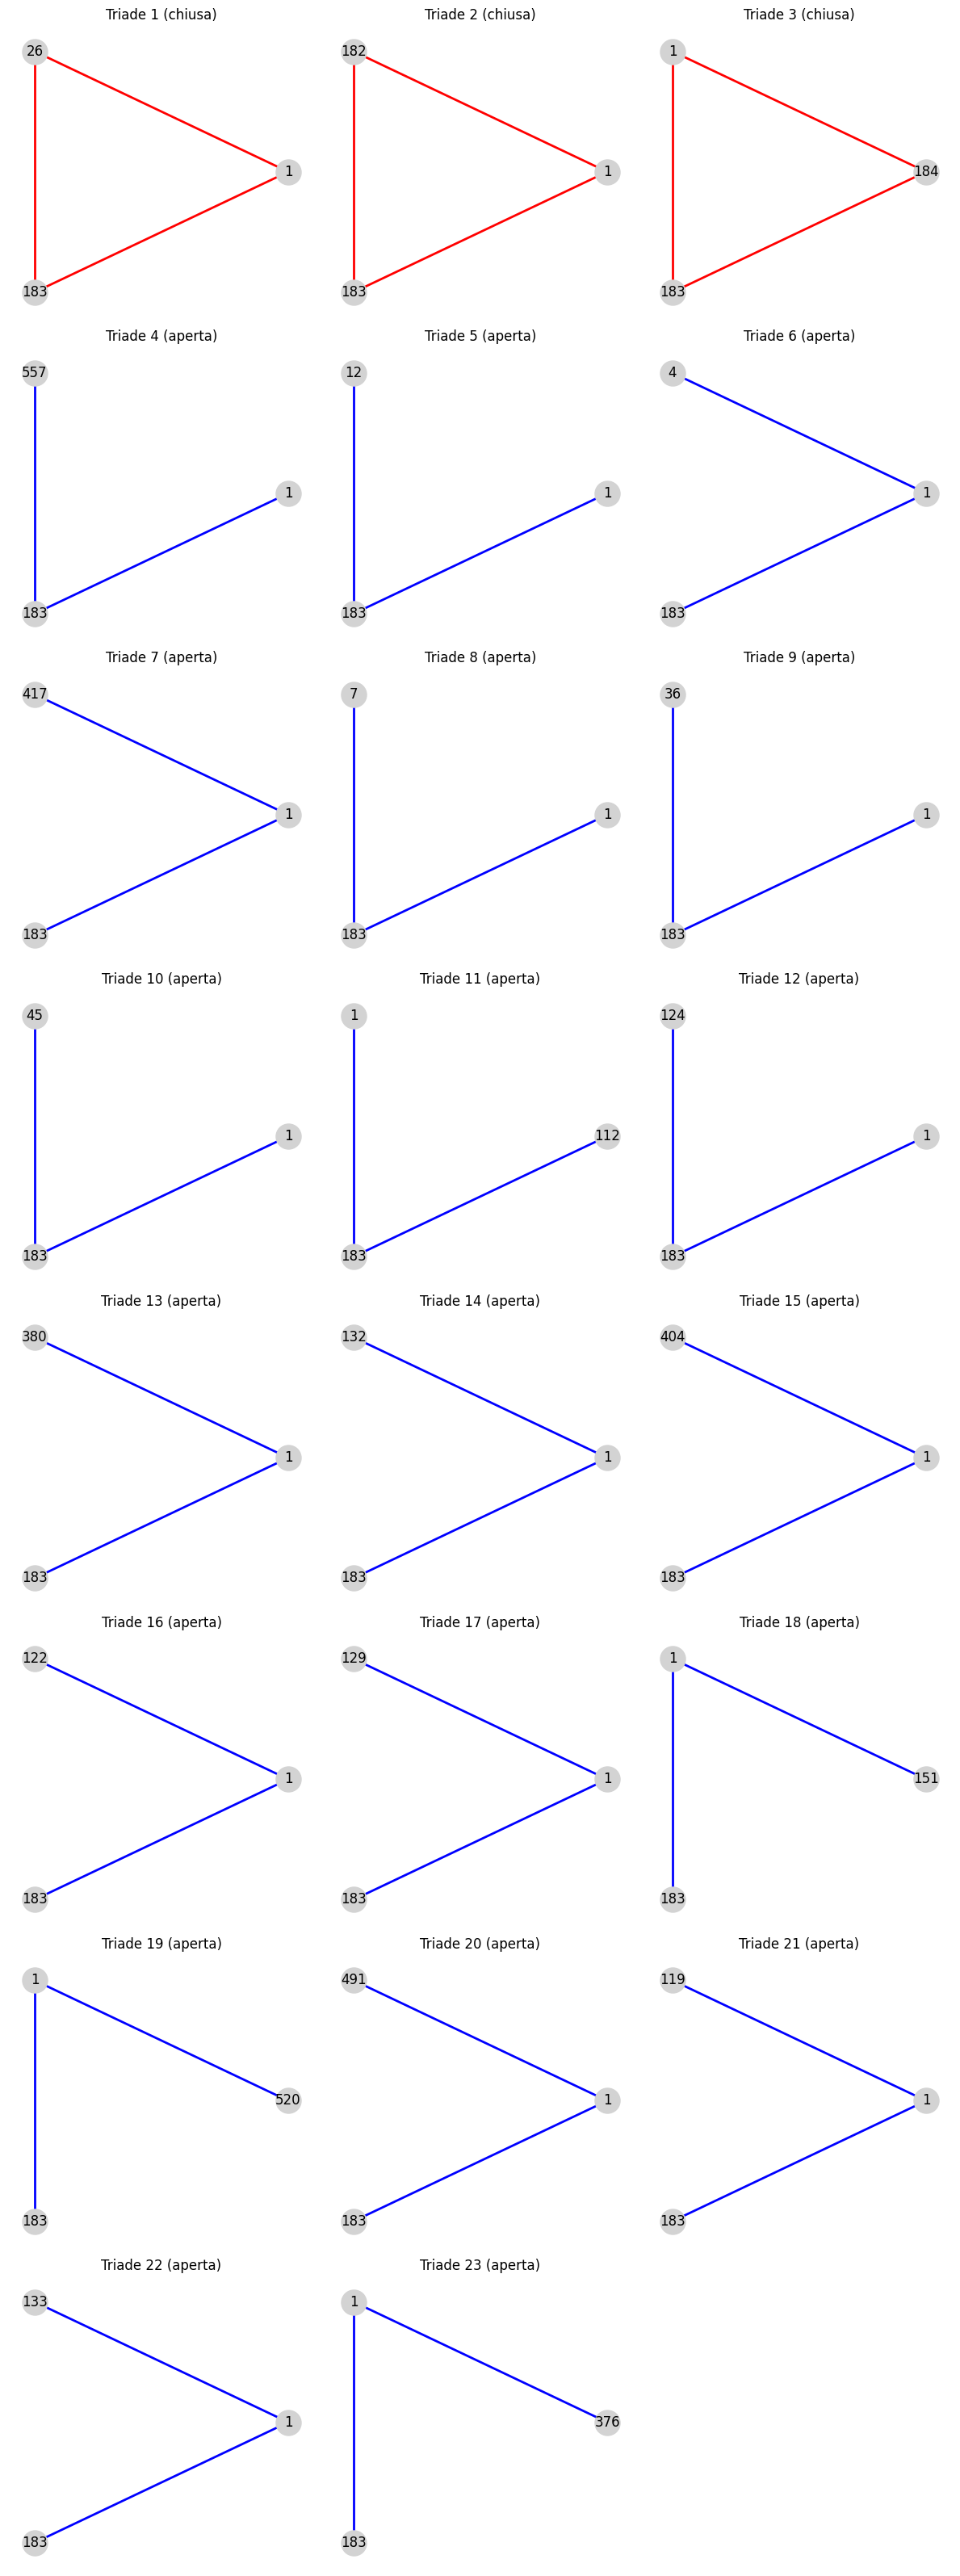

In [27]:
# 2) Triangoli per nodo (triadi chiuse)
triangles_per_node = nx.triangles(U)

# Conteggio globale triangoli (ogni triangolo contato 3 volte)
total_closed_triads = sum(triangles_per_node.values()) / 3

# Connected triples: somma su v di C(deg(v), 2)
connected_triples = sum(d * (d - 1) / 2 for _, d in U.degree())

# Triadi aperte (connected triples - triangoli)
total_open_triads = connected_triples - total_closed_triads

print(f"Closed triads (triangles): {total_closed_triads:.0f}")
print(f"Connected triples: {connected_triples:.0f}")
print(f"Open triads: {total_open_triads:.0f}")

# 3) Cerca triadi che contengono due nodi specifici (u, v)
u, v = 1, 183
if not U.has_node(u) or not U.has_node(v):
    raise ValueError(f"Uno dei nodi {u} o {v} non esiste nel grafo (componente principale)!")

closed_triads = []  # triadi chiuse: 3 archi nel sottografo non diretto
open_triads   = []  # triadi aperte: esattamente 2 archi

for x in U.nodes():
    if x in (u, v):
        continue

    trio = [u, v, x]
    subU = U.subgraph(trio)
    e = subU.number_of_edges()

    if e == 3:
        closed_triads.append(trio)
    elif e == 2:
        open_triads.append(trio)

print(f"\nTriadi chiuse che contengono {u} e {v}:")
for tri in closed_triads:
    print(f"  {tri}")

print(f"\nTriadi aperte che contengono {u} e {v}:")
for tri in open_triads:
    print(f"  {tri}")

# Punteggio triadi aperte in base al traffico totale (weight)
scored_open_triads = []
for tri in open_triads:
    subT = U.subgraph(tri)
    # Sommiamo il traffico (weight) dei due archi che compongono la triade aperta
    total_weight = sum(d['weight'] for u_edge, v_edge, d in subT.edges(data=True))
    scored_open_triads.append((total_weight, tri))

# Ordiniamo dalla triade con più traffico a quella con meno
scored_open_triads.sort(key=lambda val: val[0], reverse=True)

# Teniamo solo le prime 20
open_triads = [tri for weight, tri in scored_open_triads[:20]]

# 4) Visualizzazione triadi trovate
all_triads = closed_triads + open_triads
n = len(all_triads)

if n == 0:
    print("\nNessuna triade (aperta o chiusa) trovata per la coppia scelta.")
else:
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, tri in enumerate(all_triads, start=1):
        T = U.subgraph(tri)
        pos = nx.circular_layout(T)
        #pos = nx.spring_layout(T, seed=42)

        plt.subplot(rows, cols, i)
        color = "red" if tri in closed_triads else "blue"

        nx.draw(
            T, pos,
            with_labels=True,
            node_size=500,
            node_color="lightgray",
            edge_color=color,
            width=2
        )

        kind = "chiusa" if tri in closed_triads else "aperta"
        plt.title(f"Triade {i} ({kind})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Dimensione massima delle clique: 5
Numero di clique massime: 3


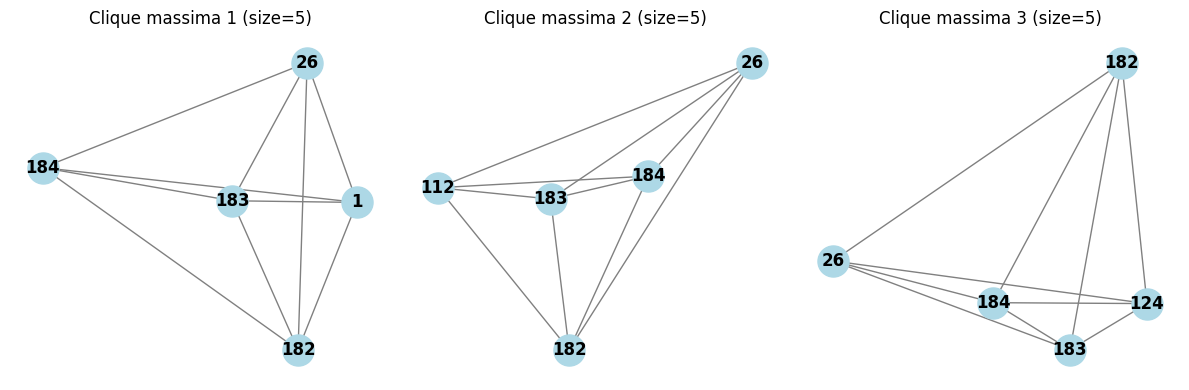

In [28]:
all_cliques = list(nx.find_cliques(U))

max_size = max(len(c) for c in all_cliques)
max_cliques = [c for c in all_cliques if len(c) == max_size]

print("Dimensione massima delle clique:", max_size)
print("Numero di clique massime:", len(max_cliques))

import matplotlib.pyplot as plt
import networkx as nx

MAX_PLOTS = 4 
to_plot = max_cliques[:MAX_PLOTS]

fig, axes = plt.subplots(1, len(to_plot), figsize=(4 * len(to_plot), 4))

if len(to_plot) == 1:
    axes = [axes]

for i, clique in enumerate(to_plot):
    C = U.subgraph(clique)
    pos = nx.spring_layout(C, seed=42)

    nx.draw(
        C, pos,
        with_labels=True,
        node_size=500,
        node_color="lightblue",
        edge_color="gray",
        font_weight="bold",
        ax=axes[i]
    )

    axes[i].set_title(f"Clique massima {i+1} (size={max_size})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


Core number massimo: 5
Nodi nel 5-core: [1, 3, 36, 133, 7, 200, 139, 12, 45, 112, 147, 182, 151, 184, 183, 26, 124, 158]


C:\Users\nicde\AppData\Local\Temp\ipykernel_23084\753273317.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


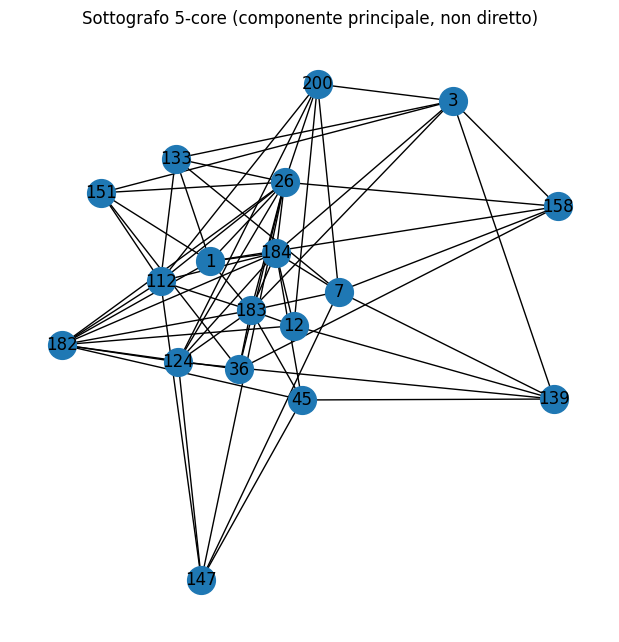

In [29]:
# Core numbers e max k-core
core_numbers = nx.core_number(U)
max_core = max(core_numbers.values())
G_kcore = nx.k_core(U, k=max_core)

print(f"Core number massimo: {max_core}")
print(f"Nodi nel {max_core}-core: {list(G_kcore.nodes())}")

# Visualizzazione del max k-core
pos = nx.spring_layout(G_kcore, seed=42)
plt.figure(figsize=(6, 6))
nx.draw(G_kcore, pos, with_labels=True, node_size=400)
plt.title(f"Sottografo {max_core}-core (componente principale, non diretto)")
plt.axis("off")
plt.tight_layout()
plt.show()

Ego network di 1: 342 nodi, 354 archi
Ego network di 3: 203 nodi, 203 archi
Ego network di 12: 81 nodi, 83 archi


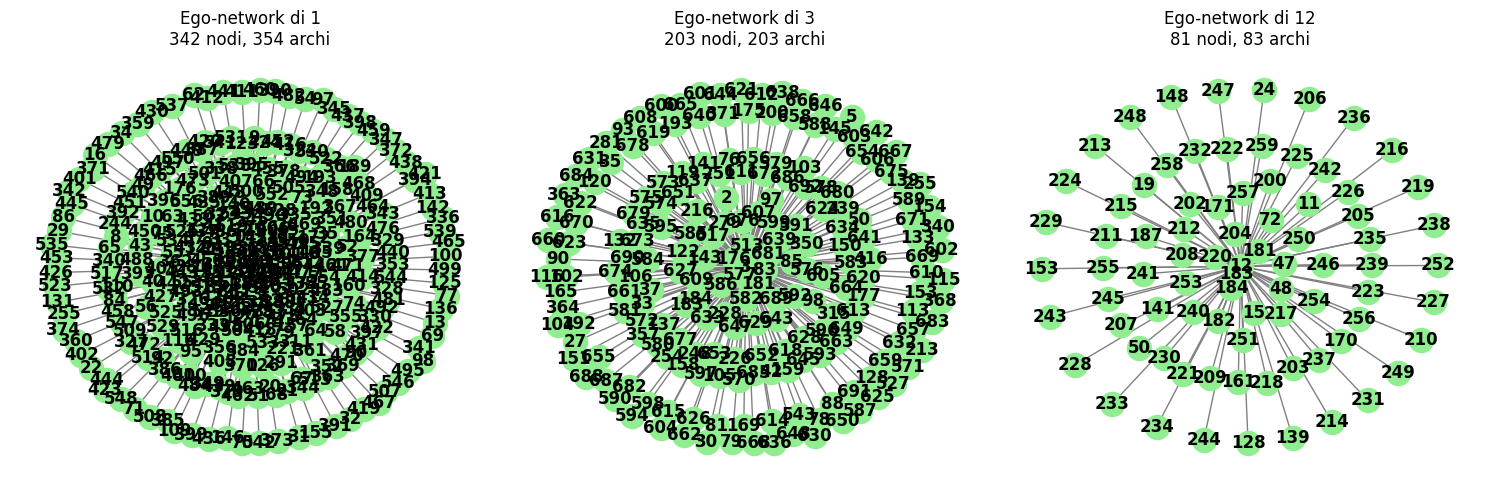

In [ ]:
# Degree centrality
degree_centrality = nx.degree_centrality(U)

top3 = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:3]
for n in top3:
    ego = nx.ego_graph(U, n)  # radius=1
    print(f"Ego network di {n}: {ego.number_of_nodes()} nodi, {ego.number_of_edges()} archi")

# Plot dei 3 ego network
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, n in zip(axes, top3):
    ego = nx.ego_graph(U, n)
    pos = nx.spring_layout(ego, seed=42)

    nx.draw(
        ego, pos,
        with_labels=True,
        node_size=300,
        node_color="lightgreen",
        edge_color="gray",
        font_weight="bold",
        ax=ax
    )
    ax.set_title(
        f"Ego-network di {n}\n"
        f"{ego.number_of_nodes()} nodi, {ego.number_of_edges()} archi"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()
